In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
import scipy as sp
from multiprocessing import Pool

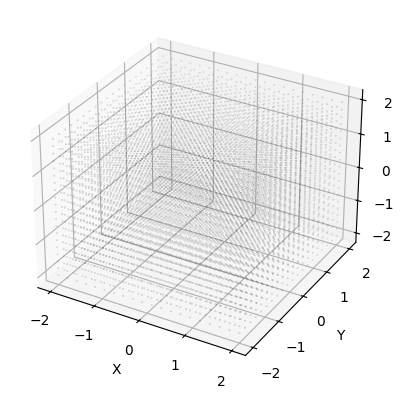

In [2]:
N_realisation =0
np.random.seed(N_realisation)
particle_line_density = 20
N0_particle = 20 ** 3

# XP0 = np.random.uniform(-2, 2, N0_particle) 
# YP0 = np.random.uniform(-2, 2, N0_particle)
# ZP0 = np.random.uniform(-2, 2, N0_particle)

xp0 = np.linspace(-2, 2, particle_line_density)
yp0 = np.linspace(-2, 2, particle_line_density)
zp0 = np.linspace(-2, 2, particle_line_density)

XP0, YP0, ZP0 = np.meshgrid(xp0, yp0, zp0, indexing='ij')

St0 = 0.1
R0 = 1
a = R0
# a, alpha, R, Fr, gravity = 1, 1, 2/3, 5, False

xl, xr = -2, 2
yl, yr = -2, 2
zd, zu = -2, 2

dx_col, dy_col, dz_col = 1, 1, 1
Nx_col, Ny_col, Nz_col = 4, 4, 4
gridA_xc, gridA_yc, gridA_zc = np.meshgrid(np.linspace(xl+dx_col/2, xr-dx_col/2, Nx_col), 
                                           np.linspace(yl+dy_col/2, yr-dy_col, Ny_col), 
                                           np.linspace(zd+dz_col/2, zu-dz_col/2, Nz_col), indexing='ij')
gridB_xc, gridB_yc, gridB_zc = np.meshgrid(np.linspace(xl, xr, Nx_col+1), np.linspace(yl, yr, Ny_col+1), np.linspace(zd, zu, Nz_col+1), indexing='ij')

# Plot grid lines
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# # Plot lines along x-axis
# for i in range(Ny_col):
#     for j in range(Nz_col):
#         ax.plot(gridA_xc[:, i, j], gridA_yc[:, i, j], gridA_zc[:, i, j], color='r',linestyle='--')

# # Plot lines along y-axis
# for i in range(Nx_col):
#     for j in range(Nz_col):
#         ax.plot(gridA_xc[i, :, j], gridA_yc[i, :, j], gridA_zc[i, :, j], color='g',linestyle='--')


# # Plot lines along z-axis
# for i in range(Nx_col):
#     for j in range(Ny_col):
#         ax.plot(gridA_xc[i, j, :], gridA_yc[i, j, :], gridA_zc[i, j, :], color='b',linestyle='--')


ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.scatter(XP0, YP0, ZP0,s=0.01, c='k', marker='o')


plt.show()

In [3]:
X, Y, Z = np.meshgrid(np.linspace(-2, 2, 101), np.linspace(-2, 2, 100), np.linspace(-2, 2, 101), indexing='ij')
if Y.any() == 0:
    raise ValueError('Y cannot be zero')
PHI = np.arctan(Z/Y)
dist = np.sqrt(X**2 + Y**2 + Z**2)
r_planar = np.sqrt(Z**2 + Y**2)

mask = dist > R0

Ux = -(2 * (r_planar)**2 + X**2 -1) / 5
Ux[mask] = (-(a**5)/15) * (2/(a**3) + (r_planar[mask]**2 - 2*(X[mask]**2))/(dist[mask]**5))

Ur = X * r_planar / 5
Ur[mask] = (a**5) * X[mask] * r_planar[mask] / (5 * dist[mask]**5)

Uy = Ur * Y / r_planar
Uz = Ur * Z / r_planar

# a simple test to verify result
# test = Uy[:, :, 50]
# plt.contourf(X[:, :, 50], Y[:, :, 50], test, 50)
# plt.colorbar()

# # Plot velocity field
# ax = plt.figure().add_subplot(projection='3d')
# ax.quiver(X, Y, Z, Ux, Uy, Uz, length=0.2, normalize=True)


# plt.show()

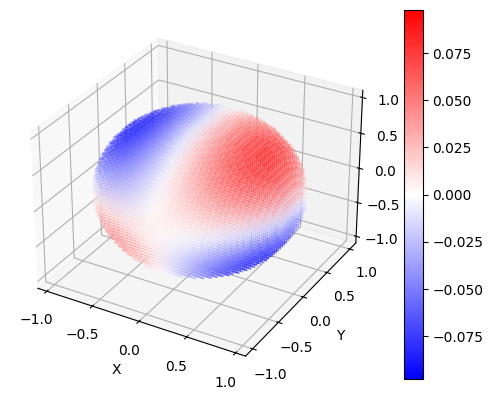

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
img = ax.scatter(X[dist<=R0], Y[dist<=R0], Z[dist<=R0], c=Uz[dist<=R0], s=0.1,  cmap='bwr')
fig.colorbar(img)
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

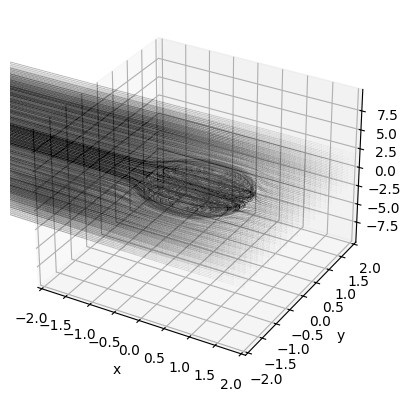

In [5]:
import advect_bubbles_3d as adv3D

Bubbles_to_adv = np.hstack((np.arange(N0_particle)[:, np.newaxis], 
                            XP0.flatten()[:, np.newaxis], YP0.flatten()[:, np.newaxis], ZP0.flatten()[:, np.newaxis], 
                            np.zeros((N0_particle, 3)), St0 * np.ones((N0_particle, 1))))

fig = plt.figure()
ax = fig.add_subplot(projection='3d')


out = adv3D.advect_bubbles(Bubbles_to_adv, 0, 150, plot_path=True, this_ax=ax, color='k')


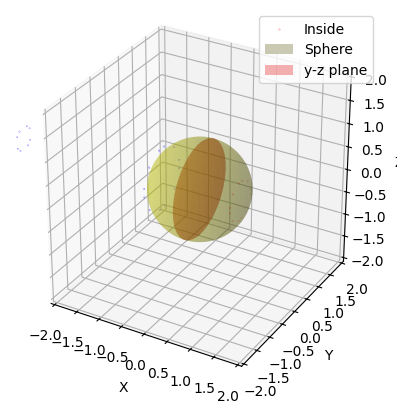

In [6]:
# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')

# ax.scatter(out[:, 0], out[:, 1], out[:, 2], s=0.1, c='k', marker='o')

# Plot grid lines

# Create data for a sphere
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = np.outer(np.cos(u), np.sin(v))
y = np.outer(np.sin(u), np.sin(v))
z = np.outer(np.ones(np.size(u)), np.cos(v))



for time in [1499]:

    inside = np.sqrt(out[:, 0, time]**2 + out[:, 1, time]**2 + out[:, 2, time]**2) <= R0
    outside = np.sqrt(out[:, 0, time]**2 + out[:, 1, time]**2 + out[:, 2, time]**2) > R0

    # inside_particles = out[inside, :, time]
    # check = np.sqrt(out[inside, 0, time]**2 + out[inside, 1, time]**2 + out[inside, 2, time]**2)
    # avg_loc = np.mean(inside_particles, axis=0)[:3]

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(out[inside, 0, time], out[inside, 1, time], out[inside, 2, time], s=0.1, c='r', marker='.', label='Inside')
    ax.scatter(out[outside, 0, time], out[outside, 1, time], out[outside, 2, time], s=0.1, c='b', marker='.')

    ax.plot_surface(x, y, z, color='y', alpha=0.3, label='Sphere')
    # Plot the y-z plane
    x_plane = np.zeros_like(y)  # Constant x values
    ax.plot_surface(x_plane, y, z, color='r', alpha=0.3, label='y-z plane')


    # ax.text(-4, 0, 2, 'aggregation at \n ({:.2f}, {:.2f}, {:.2f})'.format(avg_loc[0], avg_loc[1], avg_loc[2]))
    ax.legend()
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax.set_zlim(-2, 2)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_box_aspect([3,3,3])
    # plt.savefig('3Daggregation_{}.png'.format(time), dpi=300)
    plt.show()
    # plt.close()
    


In [7]:
time = -1
inside_particles = out[inside, :, time]
check = np.sqrt(out[inside, 0, time]**2 + out[inside, 1, time]**2 + out[inside, 2, time]**2)
avg_loc = np.mean(inside_particles, axis=0)[:3]
avg_loc

array([8.76709004e-01, 1.50759035e-14, 6.66769880e-15])

In [8]:
import cv2
import os

def create_movie_from_frames(target, frame_folder, output_path, fps=2):
    frame_files = [f for f in os.listdir(frame_folder) if f.endswith('.png') and f.startswith(target)]
    frame_files.sort(key=lambda x: int(x.split('_')[1].split('.')[0]))  

    frame = cv2.imread(os.path.join(frame_folder, frame_files[0]))
    height, width, _ = frame.shape
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # You can also use other codecs like 'XVID'
    video_writer = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    for frame_file in frame_files:
        frame = cv2.imread(os.path.join(frame_folder, frame_file))
        video_writer.write(frame)

    video_writer.release()

target = '3D'
N_realisation = 18
frame_folder = 'movies'
output_path = frame_folder + '/output_' + target +'_realisation_' + str(N_realisation) + '.mp4'
create_movie_from_frames(target, frame_folder, output_path)

IndexError: list index out of range